In [13]:
import gymnasium as gym
import highway_env

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
import random
from tqdm import trange

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
import sys
sys.path.insert(0, './HighwayEnv/scripts/')
from utils import record_videos, show_videos

In [15]:
# IMPORTANT: If you just created/modified the environment, you may need to:
# Option 1: Restart the kernel (Kernel -> Restart Kernel)
# Option 2: Reload and re-register (try this first):
import importlib
import highway_env
importlib.reload(highway_env)

# Re-register all environments
gym.register_envs(highway_env)

# Option 3: If above doesn't work, manually register the new environment:
try:
    from highway_env.envs.reverse_parking_dynObs_env import ReverseParkingDynObsEnv
    gym.register(
        id="parking-reverse-dynObs-v0",
        entry_point="highway_env.envs.reverse_parking_dynObs_env:ReverseParkingDynObsEnv",
    )
    print("✓ Environment 'parking-reverse-dynObs-v0' registered successfully!")
except Exception as e:
    print(f"⚠ Could not register environment: {e}")
    print("💡 Try restarting the kernel (Kernel -> Restart Kernel)")

✓ Environment 'parking-reverse-dynObs-v0' registered successfully!


/opt/anaconda3/envs/parking/lib/python3.10/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment exit-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/parking/lib/python3.10/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment highway-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/parking/lib/python3.10/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment highway-fast-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/parking/lib/python3.10/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment intersection-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/p

In [ ]:
# Use the new environment with dynamic obstacles
# IMPORTANT: Updated reward weights to emphasize y-position (critical for reverse parking)
# and added CEM planner configuration parameters
env = gym.make(
    "parking-reverse-dynObs-v0",  # New environment with moving obstacle!
    render_mode="rgb_array", 
    config={
        "vehicles_count": 0,  # Number of parked vehicles #random.randint(0, 25)
        "freeze_ego_vehicle": False,  # Set to True to freeze ego vehicle (for testing dynamic obstacle)
        # Dynamic obstacle settings (optional - these are defaults)
        "moving_obstacle": True,
        "moving_obstacle_speed": 1.0,  # m/s - how fast the obstacle moves
        "moving_obstacle_position": [26.0, -14.0],  # Top rightmost parking spot [x, y]
        "moving_obstacle_heading": np.pi / 2,  # Heading in radians (π/2 = pointing up, vertical),
        # Reward weights: [x, y, vx, vy, cos_h, sin_h]
        # Increased y-weight from 0.3 to 1.0 for better reverse parking performance
        "reward_weights": [1.0, 1.0, 0.1, 0.1, 0.05, 0.05],  # Emphasize position, especially y
    },
)
env = record_videos(env)
env.reset()

done = False
while not done:
    action = env.action_space.sample() # acceleration, steering_angle
    obs, reward, done, truncated, info = env.step(action) # obs: [x, y, vx, vy, cos_h, sin_h]; speed = sqrt(vx^2 + vy^2)= np.linalg.norm([vx, vy])
env.close()
show_videos()

/opt/anaconda3/envs/parking/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/mehaksingal/Documents/CS269-Parking-1/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [17]:
print("Observation format:", obs)

Observation format: OrderedDict([('observation', array([-0.09429899, -0.17856927, -0.11078673, -0.60611278, -0.17980348,
       -0.98370255])), ('achieved_goal', array([-0.09429899, -0.17856927, -0.11078673, -0.60611278, -0.17980348,
       -0.98370255])), ('desired_goal', array([2.600000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00,
       6.123234e-17, 1.000000e+00]))])


In [18]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=1000, action_repeat=2):
    data, done = [], True
    for _ in trange(size, desc="Collecting interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            if done:
              previous_obs, info = env.reset()
            obs, reward, done, truncated, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
            previous_obs = obs
    return data

env = gym.make("parking-parallel-v0")
data = collect_interaction_data(env)
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([0.1200, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000]), action=tensor([-0.4115,  0.2023]), next_state=tensor([ 1.1973e-01, -2.1850e-05, -8.2295e-02,  7.2101e-05,  1.0000e+00,
        -8.7613e-04]))


In [19]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])
print("Forward initial model on a sample transition:",
      dynamics(data[0].state.unsqueeze(0), data[0].action.unsqueeze(0)).detach())

Forward initial model on a sample transition: tensor([[ 0.1495, -0.0644,  0.0188,  0.0013,  1.0170, -0.0098]])


Train dynamics: 100%|██████████| 1500/1500 [00:03<00:00, 427.92it/s]


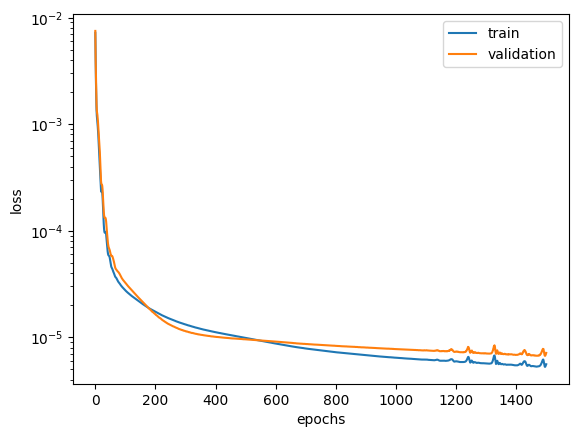

In [20]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], data[int(train_ratio * len(data)):]

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)
    for epoch in trange(epochs, desc="Train dynamics"):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["train", "validation"])
    plt.show()

train(dynamics, data, validation_data)

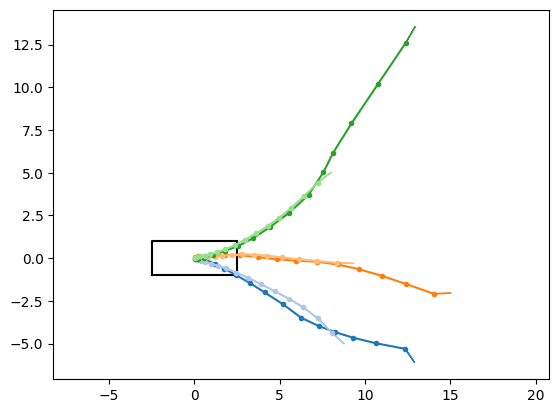

In [21]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()

visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

In [22]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

obs, info = env.reset()
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"])))

Reward of a sample transition: tensor([-0.4228])


## CEM Planner Parameters Explanation

The **Cross-Entropy Method (CEM)** planner uses iterative optimization to find the best action sequence. Here's how each parameter affects the vehicle's trajectory:

### Parameters:

1. **`horizon=10`** - Planning horizon (number of future actions to plan)
   - **Effect**: How far ahead the planner looks
   - **Higher values**: Longer-term planning, smoother trajectories, but slower computation
   - **Lower values**: More reactive, shorter-term planning, faster but may miss long-term goals
   - **For parking**: Needs to be long enough to complete the maneuver (typically 10-15 steps)

2. **`population=100`** - Number of action sequences to sample per iteration
   - **Effect**: Exploration vs exploitation trade-off
   - **Higher values**: More diverse exploration, better coverage of action space, but slower
   - **Lower values**: Faster computation, but may miss good solutions
   - **For parking**: 50-200 is typical; 100 is a good balance

3. **`selection=10`** - Number of top-performing sequences to keep (elite set)
   - **Effect**: How selective the algorithm is
   - **Higher values**: More conservative, keeps more diverse solutions, slower convergence
   - **Lower values**: More aggressive, focuses on best solutions, faster convergence but may get stuck
   - **For parking**: Typically 5-20% of population (10/100 = 10% is standard)

4. **`iterations=5`** - Number of refinement iterations
   - **Effect**: How many times to refine the action distribution
   - **Higher values**: Better optimization, more refined actions, but slower
   - **Lower values**: Faster planning, but may not converge to optimal solution
   - **For parking**: 3-10 iterations is typical; 5 is a good balance

### Additional Note:
- **`action_repeat=5`** (hardcoded in `predict_trajectory` call): Each planned action is applied for 5 time steps
  - This means `horizon=10` actions actually covers 50 time steps of simulation
  - **Effect**: Smoother execution, less frequent replanning needed
  - **Trade-off**: Less fine-grained control, but more stable trajectories

### How They Work Together:

The CEM algorithm:
1. Starts with a random distribution (mean=0, std=1) for all `horizon` actions
2. Samples `population` action sequences from this distribution
3. Evaluates each sequence by predicting the trajectory and computing rewards
4. Selects the top `selection` sequences (elite set)
5. Updates the distribution to match the elite set (refines mean and std)
6. Repeats steps 2-5 for `iterations` times
7. Returns the first action from the final optimized sequence

### Impact on Final Trajectory:

- **Smoothness**: Higher `horizon` + `action_repeat` → smoother, more predictable paths
- **Optimality**: Higher `population` + `iterations` → better solutions, closer to optimal
- **Reactivity**: Lower `horizon` → more reactive to immediate obstacles
- **Stability**: Higher `selection` ratio → more stable, less likely to get stuck in local minima
- **Speed**: Lower values across all params → faster planning, but potentially worse performance

### Recommended Settings for Parking:
- **Simple parking**: `horizon=10, population=50, selection=5, iterations=3`
- **Complex parking (with obstacles)**: `horizon=15, population=100, selection=10, iterations=5` (current)
- **Real-time constraints**: `horizon=8, population=50, selection=5, iterations=3`


In [23]:
def cem_planner(state, goal, action_size, env_config=None, horizon=None, population=None, 
                selection=None, iterations=None, gamma=None, action_repeat=None):
    """
    CEM Planner with configurable parameters from environment config.
    
    Parameters can be passed directly or read from env_config dictionary.
    If env_config is provided, it takes precedence over individual parameters.
    """
    # Get parameters from env config if available, otherwise use defaults or provided values
    if env_config is not None:
        horizon = env_config.get("cem_horizon", horizon or 15)
        population = env_config.get("cem_population", population or 150)
        selection = env_config.get("cem_selection", selection or 15)
        iterations = env_config.get("cem_iterations", iterations or 8)
        gamma = env_config.get("cem_gamma", gamma or 0.95)
        action_repeat = env_config.get("cem_action_repeat", action_repeat or 3)
    else:
        # Use provided values or defaults
        horizon = horizon or 15
        population = population or 150
        selection = selection or 15
        iterations = iterations or 8
        gamma = gamma or 0.95
        action_repeat = action_repeat or 3
    
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    
    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = torch.normal(mean=action_mean.repeat(1, population, 1), 
                              std=action_std.repeat(1, population, 1))
        actions = torch.clamp(actions, min=env.action_space.low.min(), 
                             max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=action_repeat)
        # 2. Fit the distribution to the top-k performing sequences
        # Use gamma discount to encourage reaching goal faster
        returns = reward_model(states, goal, gamma=gamma).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean = best_actions.mean(dim=1, keepdim=True)
        action_std = best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)


# Run the planner on a sample transition (using env config)
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0],
                     env_config=env.unwrapped.config)
print("Planned action:", action)
print(f"CEM Config: horizon={env.unwrapped.config.get('cem_horizon', 15)}, "
      f"population={env.unwrapped.config.get('cem_population', 150)}, "
      f"gamma={env.unwrapped.config.get('cem_gamma', 0.95)}")

Planned action: tensor([-0.4652,  0.0534])
CEM Config: horizon=15, population=150, gamma=0.95


In [ ]:
env = gym.make("parking-reverse-dynObs-v0", render_mode='rgb_array', config={
        "vehicles_count": 0,  # Number of parked vehicles
        "freeze_ego_vehicle": False,  # Set to True to freeze ego vehicle (for testing dynamic obstacle)
        # Dynamic obstacle settings (optional - these are defaults)
        "moving_obstacle": True,
        "moving_obstacle_speed": 1.0,  # m/s - how fast the obstacle moves
        "moving_obstacle_position": [26.0, -14.0],  # Top rightmost parking spot [x, y]
        "moving_obstacle_heading": np.pi / 2,  # Heading in radians (π/2 = pointing up, vertical),
        # Reward weights: [x, y, vx, vy, cos_h, sin_h]
        # Increased y-weight from 0.3 to 1.0 for better reverse parking performance
        "reward_weights": [1.0, 1.0, 0.1, 0.1, 0.05, 0.05],  # Emphasize position, especially y
    },)
env = record_videos(env)
obs, info = env.reset()

print("Environment and CEM Configuration:")
print(f"  Reward weights: {env.unwrapped.config.get('reward_weights', 'default')}")
print(f"  CEM horizon: {env.unwrapped.config.get('cem_horizon', 15)}")
print(f"  CEM population: {env.unwrapped.config.get('cem_population', 150)}")
print(f"  CEM gamma (discount): {env.unwrapped.config.get('cem_gamma', 0.95)}")
print(f"  CEM action_repeat: {env.unwrapped.config.get('cem_action_repeat', 3)}")
print()

for step in trange(3 * env.unwrapped.config["duration"], desc="Testing 3 episodes..."):
    action = cem_planner(torch.Tensor(obs["observation"]),
                         torch.Tensor(obs["desired_goal"]),
                         env.action_space.shape[0],
                         env_config=env.unwrapped.config)
    obs, reward, done, truncated, info = env.step(action.numpy())
    if done or truncated:
        obs, info = env.reset()
env.close()
show_videos()

/opt/anaconda3/envs/parking/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/mehaksingal/Documents/CS269-Parking-1/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Environment and CEM Configuration:
  Reward weights: [1.0, 1.0, 0.1, 0.1, 0.05, 0.05]
  CEM horizon: 15
  CEM population: 150
  CEM gamma (discount): 0.95
  CEM action_repeat: 3



Testing 3 episodes...: 100%|██████████| 300/300 [00:19<00:00, 15.41it/s]


In [25]:
# env = gym.make(
#     'parking-v0',
#     render_mode='rgb_array',
#     config={
#         "observation": {
#             "type": "Kinematics",
#             "cells": 128,
#         },
#         "vehicles_count": 3
#     }
# )
# env.reset()

# plt.imshow(env.render())
# plt.show()